# Assignment 2

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, LLMs, Prompting


# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Federico Ruggeri -> federico.ruggeri6@unibo.it
* Eleonora Mancini -> e.mancini@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

# Relevant Material

- Tutorial 3
- Huggingface documentation
- Huggingface hub

# Introduction

You are tasked to address the [EDOS Task A](https://github.com/rewire-online/edos) on sexism detection.

## Problem definition

Given an input text sentence, the task is to label the sentence as sexist or not sexist (binary classification).

### Examples:

**Text**: *``Schedule a date with her, then don't show up. Then text her "GOTCHA B___H".''*

**Label**: Sexist

**Text**: *``That’s completely ridiculous a woman flashing her boobs is not sexual assault in the slightest.''*

**Label**: Not sexist



## Approach

We will tackle the binary classification task with LLMs.

In particular, we'll consider zero-/few-shot prompting approaches to assess the capability of some popular open-source LLMs on this task.

## Preliminaries

We are going to download LLMs from [Huggingface](https://huggingface.co/).

Many of these open-source LLMs require you to accept their "Community License Agreement" to download them.

In summary:

- If not already, create an account of Huggingface (~2 mins)
- Check a LLM model card page (e.g., [Mistral v3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3)) and accept its "Community License Agreement".
- Go to your account -> Settings -> Access Tokens -> Create new token -> "Repositories permissions" -> add the LLM model card you want to use.
- Save the token (we'll need it later)

### Huggingface Login

Once we have created an account and an access token, we need to login to Huggingface via code.

- Type your token and press Enter
- You can say No to Github linking

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
The token `Assignment2` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `Assignment2`


After login, you can download all models associated with your access token in addition to those that are not protected by an access token.

### Data Loading

Since we are only interested in prompting, we do not require a train dataset.

We have preparared a small test set version of EDOS in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material).

Check the ``Assignment 2/data`` folder.
It contains:

- ``a2_test.csv`` → a small test set of 300 samples.
- ``demonstrations.csv`` -> a batch of 1000 samples for few-shot prompting.

Both datasets contain a balanced number of sexist and not sexist samples.


### Instructions

We require you to:

* **Download** the ``A2/data`` folder.
* **Encode** ``a2_test.csv`` into a ``pandas.DataFrame`` object.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/NLP/Assignment2/a2_test.csv')
print(df.head())

                  rewire_id  \
0  sexism2022_english-17133   
1  sexism2022_english-14197   
2   sexism2022_english-3018   
3   sexism2022_english-5301   
4  sexism2022_english-17796   

                                                text label_sexist  
0  The boys must be gaming because there goes the...   not sexist  
1  Look at those eyes. Either someone unexpectedl...       sexist  
2                  Old man mogs everyone in this sub   not sexist  
3  Excellent, I was just looking at another post ...   not sexist  
4  So you run back to daddy whenever you need hel...       sexist  


In [ ]:
df.shape

(300, 3)

# [Task 1 - 0.5 points] Model setup

Once the test data has been loaded, we have to setup the model pipeline for inference.

In particular, we have to:
- Load the model weights from Huggingface
- Quantize the model to fit into a single-GPU limited hardware

## Which LLMs?

The pool of LLMs is ever increasing and it's impossible to keep track of all new entries.

We focus on popular open-source models.

- [Mistral v2](mistralai/Mistral-7B-Instruct-v0.2)
- [Mistral v3](mistralai/Mistral-7B-Instruct-v0.3)
- [Llama v3.1](https://huggingface.co/meta-llama/Llama-3.1-8B-Instruct)
- [Phi3-mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct)

Other open-source models are more than welcome!

### Instructions

In order to get Task 1 points, we require you to:

* Pick 2 model cards from the provided list.
* For each model:
  - Define a separate section of your notebook for the model.
  - Setup a quantization configuration for the model.
  - Load the model via HuggingFace APIs.


### Notes

1. There's a popular library integrated with Huggingface's ``transformers`` to perform quantization.

2. Define two separate sections of your notebook to show that you have implemented the prompting pipeline for each selected model card.

In [ ]:
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.3 MB/s eta 0:00:00


In [2]:
import torch
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from transformers import BitsAndBytesConfig
import numpy as np
import random
from tqdm import tqdm

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model 1 - Mistral v3

In [ ]:
model_card = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(model_card)
tokenizer.pad_token = tokenizer.eos_token

# da eliminare ?!?!?! TESTARE
terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='cuda:0',
)

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.55G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 100
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.temperature = None
generation_config.num_return_sequences = 1

# [Task 2 - 1.0 points] Prompt setup

Prompting requires an input pre-processing phase where we convert each input example into a specific instruction prompt.


## Prompt Template

Use the following prompt template to process input texts.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [ ]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

In [ ]:
print(prompt)

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        [/INST]


### Instructions

In order to get Task 2 points, we require you to:

* Write a ``prepare_prompts`` function as the one reported below.

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer):
  """
    This function format input text samples into instructions prompts.

    Inputs:
      texts: input texts to classify via prompting
      prompt_template: the prompt template provided in this assignment
      tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
      input texts to classify in the form of instruction prompts
  """

  formatted_prompts = []

  for text in texts:
      formatted_text = prompt_template.format(text=text)
      tokenized_prompt = tokenizer(formatted_text, return_tensors="pt").to(device)
      formatted_prompts.append(tokenized_prompt)

  return formatted_prompts

### Notes

1. You are free to modify the prompt format (**not its content**) as you like depending on your code implementation.

2. Note that the provided prompt has placeholders. You need to format the string to replace placeholders. Huggingface might have dedicated APIs for this.

# [Task 3 - 1.0 points] Inference

We are now ready to define the inference loop where we prompt the model with each pre-processed sample.

### Instructions

In order to get Task 3 points, we require you to:

* Write a ``generate_responses`` function as the one reported below.
* Write a ``process_response`` function as the one reported below.

In [ ]:
def generate_responses(model, prompt_examples):
  """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
      model: LLM model instance for prompting
      prompt_examples: pre-processed text samples

    Outputs:
      generated responses
  """

  generated_responses = []

  for prompt in tqdm(prompt_examples):

      generated = model.generate(
          input_ids=prompt['input_ids'],
          attention_mask=prompt['attention_mask'],
          generation_config=generation_config,
      )
      generated_responses.append(generated)

  return generated_responses

In [64]:
import re

def process_response(response):
  """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
      response: generated response from LLM

    Outputs:
      parsed binary response: return 1 if YES and 0 if NO
  """

  if 'YES' in response.split('ANSWER')[-1]:
    return 1
  else:
    return 0


## Notes

1. According to our tests, it should take you ~10 mins to perform full inference on 300 samples.

# [Task 4 - 0.5 points] Metrics

In order to evaluate selected LLMs, we need to compute performance metrics.

In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes.

Moreover, we want to compute the ratio of failed responses generated by models.

That is, how frequent the LLM fails to follow instructions and provides incorrect responses that do not address the classification task.

We denote this metric as **fail-ratio**.

In summary, we parse generated responses as follows:
- 1 if the model says YES
- 0 if the model says NO
- 0 if the model does not answer in either way

### Instructions

In order to get Task 4 points, we require you to:

* Write a ``compute_metrics`` function as the one reported below.
* Compute metrics for the two selected LLMs.

In [ ]:
def compute_metrics(responses, y_true):
  """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
      responses: generated LLM responses
      y_true: ground-truth binary labels

    Outputs:
      dictionary containing desired metrics
  """

  y_preds = [process_response(response) for response in responses]

  accuracy = np.mean(np.array(y_preds) == np.array(y_true))
  fail_ratio = np.mean(np.array(y_preds) != np.array(y_true))

  return {'accuracy': accuracy, 'fail-ratio': fail_ratio}

# Dataframe to check the results

In [ ]:
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail-ratio'])

# Mistral v3 Zero-Shot testing

In [ ]:
texts = df['text'].tolist()
test = prepare_prompts(texts,prompt,tokenizer)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [06:13<00:00,  1.25s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("Mistral v3 Zero-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

Mistral v3 Zero-Shot Metrics: 

Accuracy: 0.5900
Fail-ratio: 0.4100


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'Mistralv3_0shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,Mistralv3_0_shot,0.59,0.41


In [ ]:
import json

with open('/content/drive/My Drive/NLP/Assignment2/Mistralv3_0shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# [Task 5 - 1.0 points] Few-shot Inference

So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response.

We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the prompt template as follows.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The new prompt template reports some demonstration examples to instruct the model.

Generally, we provide an equal number of demonstrations per class as shown in the example below.

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        TEXT: **example 1**
        ANSWER: YES
        TEXT: **example 2**
        ANSWER: NO

        TEXT:
        {text}

        ANSWER:
        """
    }
]

## Instructions

In order to get Task 5 points, we require you to:

- Load ``demonstrations.csv`` and encode it into a ``pandas.DataFrame`` object.
- Define a ``build_few_shot_demonstrations`` function as the one reported below.
- Perform few-shot inference as in Task 3.
- Compute metrics as in Task 4.

In [ ]:
df_demonstrations = pd.read_csv('/content/drive/My Drive/NLP/Assignment2/demonstrations.csv')

In [ ]:
df_demonstrations.head()

,rewire_id,text,label_sexist
0,sexism2022_english-10348,I would never have my kid go to a daycare with...,not sexist
1,sexism2022_english-7950,Democrat women are so butt fucking ugly.,sexist
2,sexism2022_english-7742,If you really wanted to twist the knife you’d ...,not sexist
3,sexism2022_english-16170,Those women are pro-rape. They didn’t care abo...,sexist
4,sexism2022_english-9857,Married a bitch... Is it the standard scenario...,sexist


In [ ]:
df_demonstrations.shape

(1000, 3)

In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=2):
  """
    Inputs:
      demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
      num_per_class: number of demonstrations per class

    Outputs:
      a list of textual demonstrations to inject into the prompt template.
  """

  yes_samples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(num_per_class, random_state=42)
  no_samples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(num_per_class, random_state=42)

  texts = np.concatenate([yes_samples['text'].to_numpy(), no_samples['text'].to_numpy()])
  labels = np.concatenate([['YES'] * num_per_class, ['NO'] * num_per_class])

  indices = np.random.permutation(len(texts))
  texts = texts[indices]
  labels = labels[indices]

  formatted_examples = ""
  for text, label in zip(texts, labels):
      formatted_examples += f"TEXT: **{text}**\nANSWER: {label}\n"

  return formatted_examples


#### Shuffling the examples in few-shot prompting provides several important benefits:
- Prevents Bias from Order
- Encourages Generalization
- Improves Robustness
- Mitigates Overfitting to Specific Patterns

## Prepare_prompts with examples

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer, examples):

  formatted_prompts = []
  for text in texts:
      formatted_text = prompt_template.format(text=text, examples=examples)
      tokenized_prompt = tokenizer(formatted_text, return_tensors="pt").to(device)
      formatted_prompts.append(tokenized_prompt)


  return formatted_prompts

# Mistral v3 few-shot testing with 2 examples per class

In [ ]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)
print(prompt)

<s>[INST] You are an annotator for sexism detection.

Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        [/INST]


In [ ]:
examples = build_few_shot_demonstrations(df_demonstrations)

In [ ]:
examples

'TEXT: **DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it\'d be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]**\nANSWER: NO\nTEXT: **Can\'t see much of her but she\'s hotter than any vagina-hat wearer in the Women\'s March**\nANSWER: NO\nTEXT: **nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they\'ll call it "Hate Birth"**\nANSWER: YES\nTEXT: **Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]**\nANSWER: YES\n'

In [ ]:
texts = df['text'].tolist()
test = prepare_prompts(texts,prompt,tokenizer, examples)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [14:58<00:00,  3.00s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("Mistral v3 Few-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

Mistral v3 Few-Shot Metrics: 

Accuracy: 0.7267
Fail-ratio: 0.2733


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'Mistralv3_2shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,Mistralv3_0_shot,0.590000,0.410000
1,Mistralv3_2shot,0.726667,0.273333


In [ ]:
with open('/content/drive/My Drive/NLP/Assignment2/Mistralv3_2shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# Mistral v3 few-shot testing with 3 examples per class

In [ ]:
examples = build_few_shot_demonstrations(df_demonstrations,num_per_class=3)
examples

'TEXT: **HAHAHA! Why would an alpha get married to an old hag when he has literally hundreds of hot 18-19 year olds (and older bitches too but eeewww amirite??) begging him to fuck them? Feeeemale logic.**\nANSWER: YES\nTEXT: **You mean like incels punch down on women?**\nANSWER: NO\nTEXT: **nothing irks a left wing feminist worse than seeing a beautiful virtuous woman who is conservative they HATE her H-A-T-E so they try to suppress her next it will be illegal to be born beautiful they\'ll call it "Hate Birth"**\nANSWER: YES\nTEXT: **DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it\'d be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]**\nANSWER: NO\nTEXT: **Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]**\nANSWER: YES\nTEXT: **Can\'t see much of her but she\'s hotter than any vagina-hat wearer in the Women\'

In [ ]:
test = prepare_prompts(texts,prompt,tokenizer, examples)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [17:39<00:00,  3.53s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("Mistral v3 3-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

Mistral v3 3-Shot Metrics: 

Accuracy: 0.7333
Fail-ratio: 0.2667


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'Mistralv3_3shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,Mistralv3_0_shot,0.590000,0.410000
1,Mistralv3_2shot,0.726667,0.273333
2,Mistralv3_3shot,0.733333,0.266667


In [ ]:
with open('/content/drive/My Drive/NLP/Assignment2/Mistralv3_3shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# Mistral v3 few-shot testing with 4 examples per class

In [ ]:
examples = build_few_shot_demonstrations(df_demonstrations,num_per_class=4)
examples

'TEXT: **You mean like incels punch down on women?**\nANSWER: NO\nTEXT: **Ohthisfucking fits so fking perfectly I am laughing my ass off! Scary bitch she is the devil and it is perfect it\'s in her state of ARKANSAS!!!**\nANSWER: YES\nTEXT: **Get #TRIGGERED, Hillaryfags, femme-fags, and feminazis: [URL] #MAGA #TRUMP #ELECTION2016 [URL]**\nANSWER: YES\nTEXT: **Can\'t see much of her but she\'s hotter than any vagina-hat wearer in the Women\'s March**\nANSWER: NO\nTEXT: **DOES BLACK HAMILTON STAR DRUNK-RAPE WHITE WOMEN? If you name-check the VP-Elect of the United States in a one-sided insulting harangue, it\'d be wise to delete the tweets that suggest you rape drunk white girls: #BoycottHamilton [URL]**\nANSWER: NO\nTEXT: **HAHAHA! Why would an alpha get married to an old hag when he has literally hundreds of hot 18-19 year olds (and older bitches too but eeewww amirite??) begging him to fuck them? Feeeemale logic.**\nANSWER: YES\nTEXT: **Once a pretty Jewish girl Worked at a place I us

In [ ]:
test = prepare_prompts(texts,prompt,tokenizer, examples)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [21:03<00:00,  4.21s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("Mistral v3 4-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

Mistral v3 4-Shot Metrics: 

Accuracy: 0.7133
Fail-ratio: 0.2867


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'Mistralv3_4shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,Mistralv3_0_shot,0.590000,0.410000
1,Mistralv3_2shot,0.726667,0.273333
2,Mistralv3_3shot,0.733333,0.266667
3,Mistralv3_4shot,0.713333,0.286667


In [ ]:
model_metrics.to_csv('/content/drive/My Drive/NLP/Assignment2/Mistral-metrics.csv', index=False)

In [ ]:
with open('/content/drive/My Drive/NLP/Assignment2/Mistralv3_4shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# Model 2 - LLama-3.1

In [ ]:
model_card = "meta-llama/Meta-Llama-3.1-8B-Instruct"

tokenizer = AutoTokenizer.from_pretrained(model_card)
tokenizer.pad_token = tokenizer.eos_token

terminators = [
    tokenizer.eos_token_id,
    tokenizer.convert_tokens_to_ids("<|eot_id|>")
]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_card,
    return_dict=True,
    quantization_config=bnb_config,
    device_map='auto'
)

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

In [ ]:
generation_config = model.generation_config
generation_config.max_new_tokens = 100
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.pad_token_id = tokenizer.eos_token_id
generation_config.temperature = None
generation_config.num_return_sequences = 1

# LLama-3.1 zero-shot testing

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [ ]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer):

  formatted_prompts = []

  for text in texts:
      formatted_text = prompt_template.format(text=text)
      tokenized_prompt = tokenizer(formatted_text, return_tensors="pt").to(device)
      formatted_prompts.append(tokenized_prompt)

  return formatted_prompts

In [ ]:
texts = df['text'].tolist()
test = prepare_prompts(texts,prompt,tokenizer)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [05:53<00:00,  1.18s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("LLama-3.1 Zero-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

LLama-3.1 Zero-Shot Metrics: 

Accuracy: 0.6233
Fail-ratio: 0.3767


In [ ]:
model_metrics = pd.DataFrame(columns=['model', 'accuracy', 'fail-ratio'])

In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'LLama3.1_0shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,LLama3.1_0shot,0.623333,0.376667


In [ ]:
import json

with open('/content/drive/My Drive/NLP/Assignment2/LLama3.1_0shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# LLama-3.1 few-shot testing with 2 examples per class

In [ ]:
prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [ ]:
prompt = tokenizer.apply_chat_template(prompt, tokenize=False, add_generation_prompt=True)

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer, examples):

  formatted_prompts = []
  for text in texts:
      formatted_text = prompt_template.format(text=text, examples=examples)
      tokenized_prompt = tokenizer(formatted_text, return_tensors="pt").to(device)
      formatted_prompts.append(tokenized_prompt)


  return formatted_prompts

In [ ]:
df_demonstrations = pd.read_csv('/content/drive/My Drive/NLP/Assignment2/demonstrations.csv')
examples = build_few_shot_demonstrations(df_demonstrations)
texts = df['text'].tolist()
test = prepare_prompts(texts,prompt,tokenizer,examples)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [11:24<00:00,  2.28s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("LLama-3.1 2-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

LLama-3.1 2-Shot Metrics: 

Accuracy: 0.6200
Fail-ratio: 0.3800


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'LLama3.1_2shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,LLama3.1_0shot,0.623333,0.376667
1,LLama3.1_2shot,0.620000,0.380000


In [ ]:
with open('/content/drive/My Drive/NLP/Assignment2/LLama3.1_2shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# LLama-3.1 few-shot testing with 3 examples per class

In [ ]:
examples = build_few_shot_demonstrations(df_demonstrations,3)
texts = df['text'].tolist()
test = prepare_prompts(texts,prompt,tokenizer,examples)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [13:55<00:00,  2.78s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("LLama-3.1 Few-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

LLama-3.1 Few-Shot Metrics: 

Accuracy: 0.6933
Fail-ratio: 0.3067


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'LLama3.1_3shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,LLama3.1_0shot,0.623333,0.376667
1,LLama3.1_2shot,0.620000,0.380000
2,LLama3.1_3shot,0.693333,0.306667


In [ ]:
with open('/content/drive/My Drive/NLP/Assignment2/LLama3.1_3shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

# LLama-3.1 few-shot testing with 4 examples per class

In [ ]:
examples = build_few_shot_demonstrations(df_demonstrations,4)
texts = df['text'].tolist()
test = prepare_prompts(texts,prompt,tokenizer,examples)

In [ ]:
responses = generate_responses(model, test)

100%|██████████| 300/300 [16:56<00:00,  3.39s/it]


In [ ]:
decoded_responses = [tokenizer.decode(response[0], skip_special_tokens=True) for response in responses]

y_true = df['label_sexist'].tolist()
y_true = [1 if y == 'sexist' else 0 for y in y_true]

mistral_metrics = compute_metrics(decoded_responses, y_true)

print("LLama-3.1 Few-Shot Metrics: \n")
print(f"Accuracy: {mistral_metrics['accuracy']:.4f}")
print(f"Fail-ratio: {mistral_metrics['fail-ratio']:.4f}")

LLama-3.1 Few-Shot Metrics: 

Accuracy: 0.7000
Fail-ratio: 0.3000


In [ ]:
model_metrics.loc[len(model_metrics)] = {'model': 'LLama3.1_4shot', **mistral_metrics}

In [ ]:
model_metrics

,model,accuracy,fail-ratio
0,LLama3.1_0shot,0.623333,0.376667
1,LLama3.1_2shot,0.620000,0.380000
2,LLama3.1_3shot,0.693333,0.306667
3,LLama3.1_4shot,0.700000,0.300000


In [ ]:
model_metrics.to_csv('/content/drive/My Drive/NLP/Assignment2/LLama3.1-metrics.csv', index=False)

In [ ]:
with open('/content/drive/My Drive/NLP/Assignment2/LLama3.1_4shot_responses.json', 'w') as json_file:
    json.dump(decoded_responses, json_file)

## Notes

1. You are free to pick any value for ``num_per_class``.

2. According to our tests, few-shot prompting increases inference time by some minutes (we experimented with ``num_per_class`` $\in [2, 4]$).

# [Task 6 - 1.0 points] Error Analysis

We are now interested in evaluating model responses and comparing their performance.

This analysis helps us in understanding

- Classification task performance gap: are the models good at this task?
- Generation quality: which kind of responses do models generate?
- Errors: which kind of mistakes do models do?

### Instructions

In order to get Task 6 points, we require you to:

* Compare classification performance of selected LLMs in a Table.
* Compute confusion matrices for selected LLMs.
* Briefly summarize your observations on generated responses.

In [70]:
import pandas as pd
import json

LLama_df_metrics = pd.read_csv('/content/drive/My Drive/NLP/Assignment2/LLama3.1-metrics.csv')
Mistral_df_metrics = pd.read_csv('/content/drive/My Drive/NLP/Assignment2/Mistral-metrics.csv')

LLama_files = [
    '/content/drive/My Drive/NLP/Assignment2/LLama3.1_0shot_responses.json',
    '/content/drive/My Drive/NLP/Assignment2/LLama3.1_2shot_responses.json',
    '/content/drive/My Drive/NLP/Assignment2/LLama3.1_3shot_responses.json',
    '/content/drive/My Drive/NLP/Assignment2/LLama3.1_4shot_responses.json',
]

Mistral_files = [
    '/content/drive/My Drive/NLP/Assignment2/Mistralv3_0shot_responses.json',
    '/content/drive/My Drive/NLP/Assignment2/Mistralv3_2shot_responses.json',
    '/content/drive/My Drive/NLP/Assignment2/Mistralv3_3shot_responses.json',
    '/content/drive/My Drive/NLP/Assignment2/Mistralv3_4shot_responses.json',
]

LLama_responses = []
Mistral_responses = []

def load_responses(files, response_list):
    for file_path in files:
        with open(file_path, 'r') as file:
            responses = json.load(file)
            response_list.append(responses)

load_responses(LLama_files, LLama_responses)
load_responses(Mistral_files, Mistral_responses)

In [35]:
print("LLama3.1 metrics")
LLama_df_metrics

LLama3.1 metrics


,model,accuracy,fail-ratio
0,LLama3.1_0shot,0.623333,0.376667
1,LLama3.1_2shot,0.620000,0.380000
2,LLama3.1_3shot,0.693333,0.306667
3,LLama3.1_4shot,0.700000,0.300000


In [36]:
print("Mistralv3 metrics")
Mistral_df_metrics

Mistralv3 metrics


,model,accuracy,fail-ratio
0,Mistralv3_0shot,0.590000,0.410000
1,Mistralv3_2shot,0.726667,0.273333
2,Mistralv3_3shot,0.733333,0.266667
3,Mistralv3_4shot,0.713333,0.286667


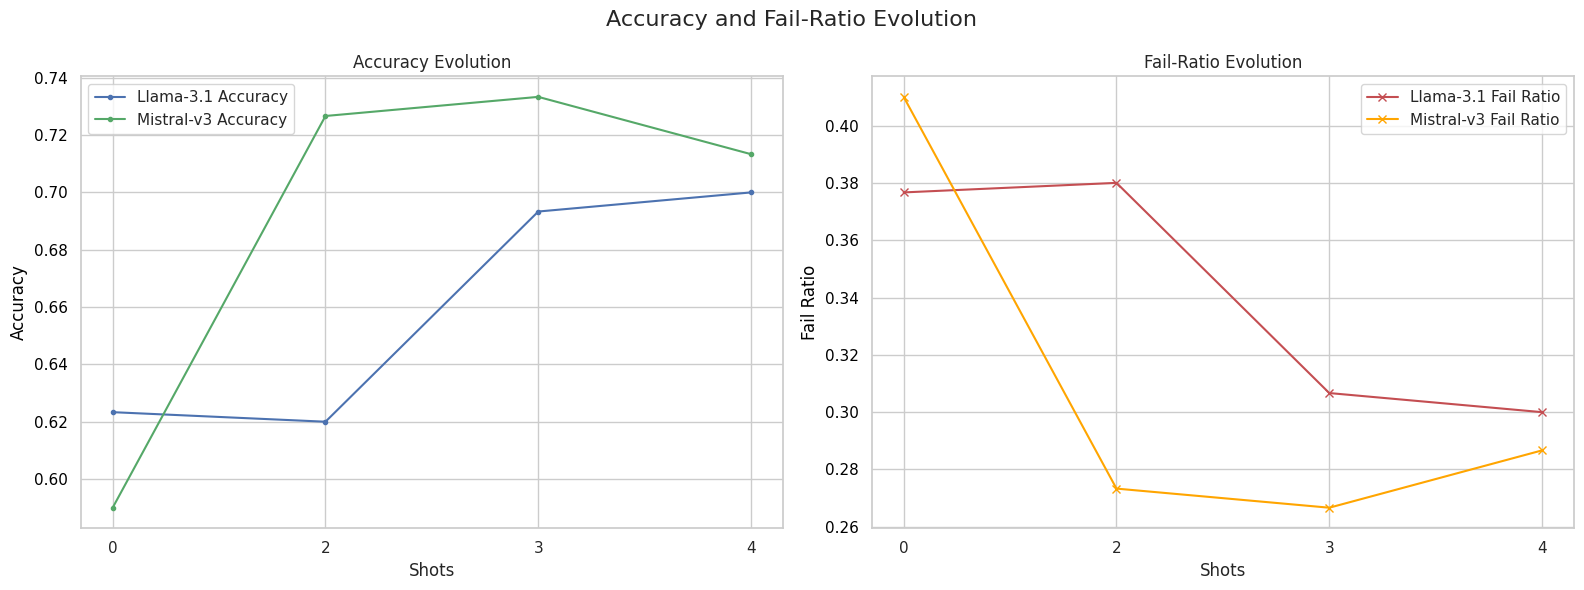

In [71]:
import matplotlib.pyplot as plt

performance_df = (
    LLama_df_metrics.assign(shots=LLama_df_metrics['model'].str.extract(r'_(\d+)'))
    .merge(Mistral_df_metrics.assign(shots=Mistral_df_metrics['model'].str.extract(r'_(\d+)')), on="shots", suffixes=('_llama', '_mistral'))
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(performance_df['shots'], performance_df['accuracy_llama'], label='Llama-3.1 Accuracy', marker='.', color='b')
ax1.plot(performance_df['shots'], performance_df['accuracy_mistral'], label='Mistral-v3 Accuracy', marker='.', color='g')
ax1.set_xlabel('Shots')
ax1.set_ylabel('Accuracy', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_title('Accuracy Evolution')
ax1.legend(loc='upper left')
ax1.grid(True)

ax2.plot(performance_df['shots'], performance_df['fail-ratio_llama'], label='Llama-3.1 Fail Ratio', marker='x', color='r')
ax2.plot(performance_df['shots'], performance_df['fail-ratio_mistral'], label='Mistral-v3 Fail Ratio', marker='x', color='orange')
ax2.set_xlabel('Shots')
ax2.set_ylabel('Fail Ratio', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set_title('Fail-Ratio Evolution')
ax2.legend(loc='upper right')
ax2.grid(True)

fig.suptitle('Accuracy and Fail-Ratio Evolution', fontsize=16)

plt.tight_layout()
plt.show()


In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

df = pd.read_csv('/content/drive/My Drive/NLP/Assignment2/a2_test.csv')
gd = [1 if y == 'sexist' else 0 for y in df['label_sexist']]

llama_preds = []
for responses in LLama_responses:
    preds = []
    for response in responses:
        preds.append(process_response(response))
    llama_preds.append(preds)

mistral_preds = []
for responses in Mistral_responses:
    preds = []
    for response in responses:
        preds.append(process_response(response))
    mistral_preds.append(preds)

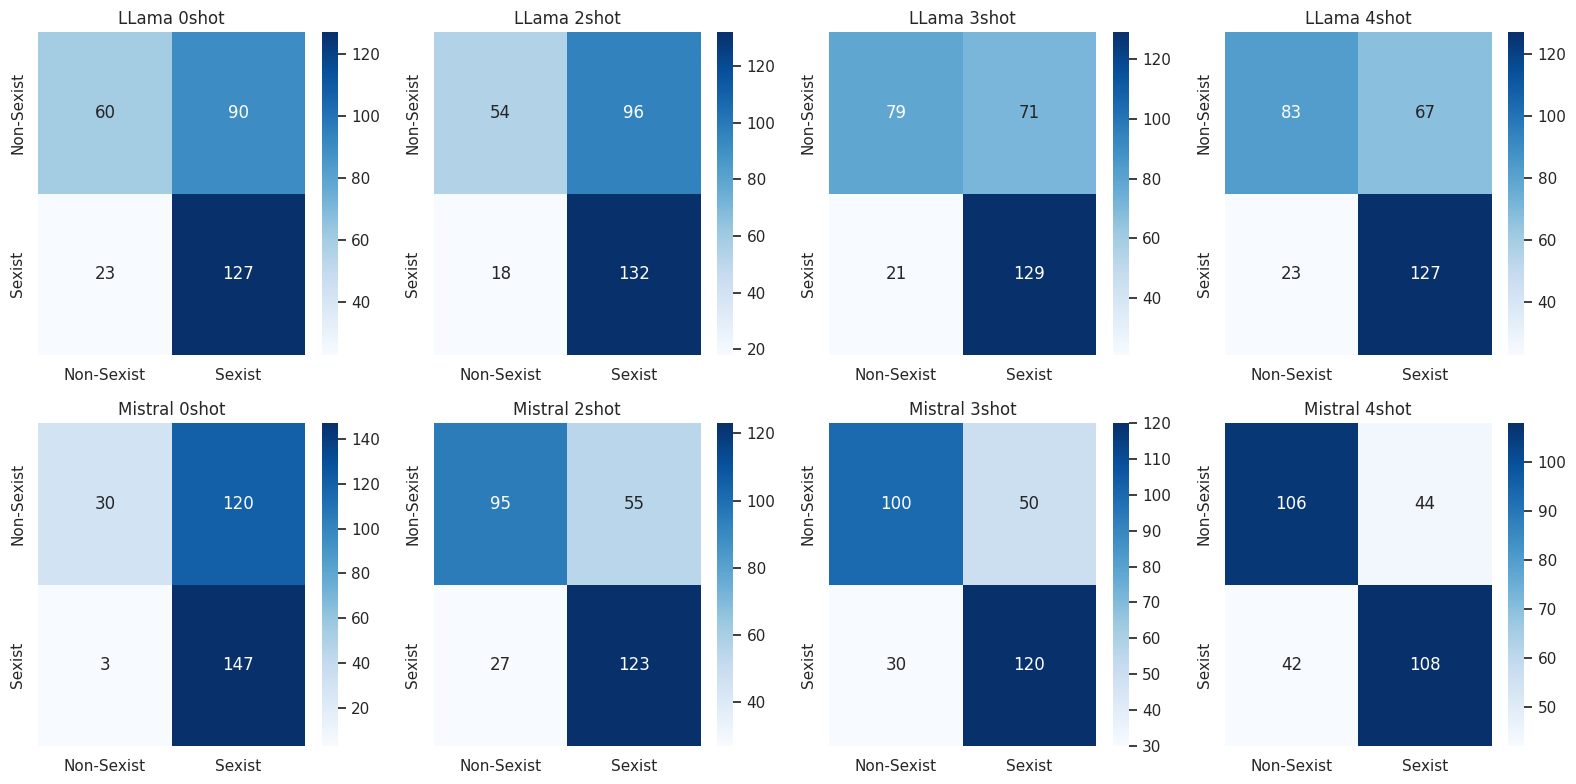

In [80]:
shots = [0, 2, 3, 4]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, shot in enumerate(shots):
    confusion_llama = confusion_matrix(gd, llama_preds[i])
    sns.heatmap(confusion_llama, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sexist', 'Sexist'],
                yticklabels=['Non-Sexist', 'Sexist'], ax=axes[0, i])
    axes[0, i].set_title(f'LLama {shot}shot')

    confusion_mistral = confusion_matrix(gd, mistral_preds[i])
    sns.heatmap(confusion_mistral, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Sexist', 'Sexist'],
                yticklabels=['Non-Sexist', 'Sexist'], ax=axes[1, i])
    axes[1, i].set_title(f'Mistral {shot}shot')

plt.tight_layout()
plt.show()


In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score

shots = [0, 2, 3, 4]
metrics_llama = {'Precision': [], 'Recall': [], 'F1-Score': [], 'FPR': [], 'FNR': []}
metrics_mistral = {'Precision': [], 'Recall': [], 'F1-Score': [], 'FPR': [], 'FNR': []}

def false_positive_rate(conf_matrix):
    FP = conf_matrix[0, 1]
    TN = conf_matrix[1, 1]
    return FP / (FP + TN)

def false_negative_rate(conf_matrix):
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]
    return FN / (FN + TP)

for i, shot in enumerate(shots):
    confusion_llama = confusion_matrix(gd, llama_preds[i])

    precision_llama = precision_score(gd, llama_preds[i])
    recall_llama = recall_score(gd, llama_preds[i])
    f1_llama = f1_score(gd, llama_preds[i])
    fpr_llama = false_positive_rate(confusion_llama)
    fnr_llama = false_negative_rate(confusion_llama)

    metrics_llama['Precision'].append(precision_llama)
    metrics_llama['Recall'].append(recall_llama)
    metrics_llama['F1-Score'].append(f1_llama)
    metrics_llama['FPR'].append(fpr_llama)
    metrics_llama['FNR'].append(fnr_llama)

    confusion_mistral = confusion_matrix(gd, mistral_preds[i])

    precision_mistral = precision_score(gd, mistral_preds[i])
    recall_mistral = recall_score(gd, mistral_preds[i])
    f1_mistral = f1_score(gd, mistral_preds[i])
    fpr_mistral = false_positive_rate(confusion_mistral)
    fnr_mistral = false_negative_rate(confusion_mistral)

    metrics_mistral['Precision'].append(precision_mistral)
    metrics_mistral['Recall'].append(recall_mistral)
    metrics_mistral['F1-Score'].append(f1_mistral)
    metrics_mistral['FPR'].append(fpr_mistral)
    metrics_mistral['FNR'].append(fnr_mistral)

statistics_df = pd.DataFrame({
    'Shot': shots,
    'LLama Precision': metrics_llama['Precision'],
    'Mistral Precision': metrics_mistral['Precision'],
    'LLama Recall': metrics_llama['Recall'],
    'Mistral Recall': metrics_mistral['Recall'],
    'LLama F1-Score': metrics_llama['F1-Score'],
    'Mistral F1-Score': metrics_mistral['F1-Score'],
    'LLama FPR': metrics_llama['FPR'],
    'Mistral FPR': metrics_mistral['FPR'],
    'LLama FNR': metrics_llama['FNR'],
    'Mistral FNR': metrics_mistral['FNR']
})

statistics_df


,Shot,LLama Precision,Mistral Precision,LLama Recall,Mistral Recall,LLama F1-Score,Mistral F1-Score,LLama FPR,Mistral FPR,LLama FNR,Mistral FNR
0,0,0.585253,0.550562,0.846667,0.98,0.692098,0.705036,0.414747,0.449438,0.153333,0.02
1,2,0.578947,0.691011,0.880000,0.82,0.698413,0.750000,0.421053,0.308989,0.120000,0.18
2,3,0.645000,0.705882,0.860000,0.80,0.737143,0.750000,0.355000,0.294118,0.140000,0.20
3,4,0.654639,0.710526,0.846667,0.72,0.738372,0.715232,0.345361,0.289474,0.153333,0.28


In [85]:
statistics_df.to_csv('/content/drive/My Drive/NLP/Assignment2/statistics.csv', index=False)

### **Conclusioni e Analisi Dettagliata**

Dai risultati delle metriche di valutazione (Precisione, Recall, F1-Score, FPR, FNR) per i modelli LLama e Mistral su differenti configurazioni di "shot" (0-shot, 2-shot, 3-shot, 4-shot), possiamo fare alcune osservazioni critiche e valutare le performance relative di entrambi i modelli.

#### **1. Precisione:**
- **LLama** mostra una precisione che rimane relativamente stabile e leggermente crescente con l'aumentare degli "shot", passando da **0.585** a **0.654**. Questo indica che, man mano che il modello ha accesso a più esempi di addestramento (più "shot"), diventa leggermente più preciso nel classificare correttamente le risposte "sexist".
- **Mistral** ha una precisione che aumenta in modo più significativo, partendo da **0.550** al 0-shot e arrivando a **0.710** al 4-shot. Questo miglioramento suggerisce che Mistral beneficia maggiormente dell'addestramento con più esempi (shots), riuscendo a migliorare la sua capacità di rilevare risposte "sexist" senza includere troppi falsi positivi.

#### **2. Recall:**
- **LLama** ha un recall che rimane molto alto (sopra l'84%) e si riduce leggermente man mano che gli "shot" aumentano. Questo indica che LLama è molto bravo a identificare le risposte "sexist" ma può avere una lieve perdita di rilevamento all'aumentare dei dati di addestramento.
- **Mistral** ha un recall che è inizialmente molto alto (0.98 al 0-shot) ma decresce significativamente man mano che il numero di "shot" aumenta, arrivando a **0.72** al 4-shot. Questo è un segnale negativo, poiché il modello diventa meno sensibile all'identificazione delle risposte "sexist" con l'aumento della complessità del task (più esempi).

#### **3. F1-Score:**
- **LLama** mostra un miglioramento progressivo nel suo F1-score, che aumenta da **0.692** a **0.738** con l'aumentare degli "shot". Questo suggerisce che LLama riesce a bilanciare bene precisione e recall, migliorando gradualmente la sua performance complessiva in tutti gli "shot".
- **Mistral**, sebbene abbia un F1-score inizialmente più alto rispetto a LLama al 0-shot (**0.705**), non migliora altrettanto significativamente, mostrando un F1-score di **0.715** al 4-shot, che è inferiore a quello di LLama. Questo indica che Mistral non riesce a migliorare l'equilibrio tra precisione e recall tanto quanto LLama quando si passa a configurazioni con più esempi.

#### **4. False Positive Rate (FPR):**
- **LLama** ha un FPR che diminuisce con l'aumentare degli "shot", passando da **0.415** al 0-shot a **0.345** al 4-shot. Questo suggerisce che LLama diventa più preciso nel non classificare erroneamente risposte non "sexist" come "sexist" man mano che aumenta il numero di esempi.
- **Mistral** ha un FPR che è inizialmente più alto di LLama, ma migliora progressivamente, passando da **0.449** al 0-shot a **0.289** al 4-shot. Nonostante il miglioramento, Mistral continua a mostrare un FPR più elevato rispetto a LLama, suggerendo che potrebbe essere meno preciso nel distinguere le risposte "sexist" da quelle non "sexist".

#### **5. False Negative Rate (FNR):**
- **LLama** mantiene un FNR stabile e relativamente basso, che varia da **0.153** al 0-shot a **0.153** al 4-shot. Questo è un segnale positivo, in quanto significa che LLama riesce a ridurre costantemente il numero di risposte "sexist" non rilevate.
- **Mistral**, invece, mostra un FNR che aumenta progressivamente, passando da **0.02** al 0-shot a **0.28** al 4-shot. Questo è un dato preoccupante, poiché indica che Mistral diventa meno sensibile nel rilevare risposte "sexist" man mano che il numero di "shot" cresce, aumentando significativamente il numero di risposte "sexist" non rilevate (falsi negativi).

### **Sintesi e Conclusioni:**

- **LLama** emerge come il modello più robusto e stabile, con performance costantemente buone in tutte le metriche, in particolare nel mantenere un basso FNR (falsi negativi) e un buon equilibrio tra precisione e recall. L'aumento degli "shot" porta a miglioramenti nella precisione e nell'F1-score, mentre il modello mantiene una bassa incidenza di falsi positivi e falsi negativi.
- **Mistral**, pur mostrando un buon miglioramento nella precisione con l'aumentare degli "shot", presenta un comportamento più problematico quando si tratta di recall e FNR. La sua performance peggiora significativamente nel rilevamento delle risposte "sexist" con l'aumentare del numero di esempi di addestramento (shot), il che porta a un aumento dei falsi negativi. Questo è un segnale di instabilità e potrebbe indicare che Mistral non gestisce bene la complessità maggiore con più dati di addestramento.

**In conclusione**, se l'obiettivo è minimizzare i falsi negativi e ottenere un buon bilanciamento tra precisione e recall, **LLama** è il modello che mostra performance superiori e più consistenti su tutti i livelli di "shot". **Mistral**, pur essendo competitivo nel 0-shot, tende a deteriorarsi nelle versioni successive, evidenziando una possibile difficoltà nel gestire aumenti nella quantità di dati di addestramento.


# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

# FAQ

Please check this frequently asked questions before contacting us.

### Model cards

You can pick any open-source model card you like.

We recommend starting from those reported in this assignment.

### Implementation

Everything can be done via ``transformers`` APIs.

However, you are free to test frameworks, such as [LangChain](https://www.langchain.com/), [LlamaIndex](https://www.llamaindex.ai/) [LitParrot](https://github.com/awesome-software/lit-parrot), provided that you correctly address task instructions.

### Bonus Points

0.5 bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
- Evaluate A1 dataset and perform comparison

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

### Prompt Template

Do not change the provided prompt template.

You are only allowed to change it in case of a possible extension.

### Optimizations

Any kind of code optimization (e.g., speedup model inference or reduce computational cost) is more than welcome!

# The End